# HOMEWORK 3

This homework involves designing a closed loop system with a PID controller.

In [1]:
!pip -q install controlSBML
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
import sympy
print("controlSBML version: " + ctl.__version__)

controlSBML version: 0.2.13


In [8]:
# Use the local file if it's available
try: 
    BIOMD823 = "/home/ubuntu/controlSBML/data/BIOMD0000000823.xml"
    _ = ctl.ControlSBML(BIOMD823)
except:
    BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

In this homework, you will design a closed loop system for controlling pDEPTOR in the mTOR system as modelled in BioModels 823.
Use pAkt as the control input.
1. Build. (4 pt) Implement the function ``evaluateDesign``, a "factory" for creating an evaluation testbed for a control design
for a testbed for the mTOR ssytem.
    1. Develop a function ``makeTestbed`` that returns a ``control.Interconnect`` object for the testbed.
        * Inputs: name, model_reference (antimony string, url), and the design parameters kp, ki, kd, kf
        * Outputs: control.Interconnect
   1. Develop a function ``evaluateDesign`` that plots the output of the closed loop system (y(t) + n(t))
1. Design. (2 pt) Use the ``evaluateDesign`` function to design a system with the following characteristics:
   1. No bias for a step response in the reference;
   1. Settles within 10 seconds;
   1. No oscillations after 10 seconds.
1. Analysis. (3 pt) Construct the $G(s)$ transfer function and $H_{NY}$ for the design parameters you used in (2)
at time 1.
Use these transfer functions to answer the following questions about how the system should behave *in theory*.
   1. Why are large control inputs required to control the mTOR system?
   1. Why are there no long term oscillations in the closed loop system?
   1. How will a step increase in noise affect the output of the closed loop system?
1. Discussion. (1 pt) Plot the values of pAkt for the closed loop system you designed in (2).
What issues do you see with using this closed loop system in practice?

# Q1. Build

In [9]:
def evaluateDesign(
      model_reference=BIOMD823, 
      kp=1000, ki=2, kd=0, kf=None, noise_amp=0, noise_frq=20, disturbance_amp=0, disturbance_frq=2,
      step_size=1, end_time=100, is_plot=True,
      **kwargs):
    """
    Create an evaluation test and plots the step response.
    
    Parameters
    ----------
    name: str
        Name of the resulting Interconncted system
    model_reference: str
        antimony string or file path or URL
    kp: float
    ki: float
    kd: float
    kf: float
    step_size: float
    kwargs: dict
        plot options
    
    """
    ctlsb = ctl.ControlSBML(
        model_reference=model_reference,
        input_names=["pAkt"], output_names=["pDEPTOR"])
    siso = ctl.SISOClosedLoopSystem(ctlsb)
    closed_loop_outputs=["entry.out", "sum_R_F.out", 
          "sum_U_D.out", "exit.out"]
    siso.makeClosedLoopSystem("cl_sys", kp=kp, ki=ki, kd=kd, kf=kf,
        noise_amp=noise_amp, noise_frq=noise_frq,
        disturbance_amp=disturbance_amp, disturbance_frq=disturbance_frq,
        closed_loop_outputs=closed_loop_outputs)
    ts = siso.makeStepResponse(time=1, step_size=1, end_time=end_time,
      points_per_time=2)
    ts.columns = ["input", "e(t)", "system.in", "output"]
    if is_plot:
        ctl.plotOneTS(ts, **kwargs)
    
# Tests
evaluateDesign(end_time=20, kp=3000, ylim=[-2, 2], figsize=[15, 5], is_plot=False)
print("OK!")

OK!


# Q2. Design

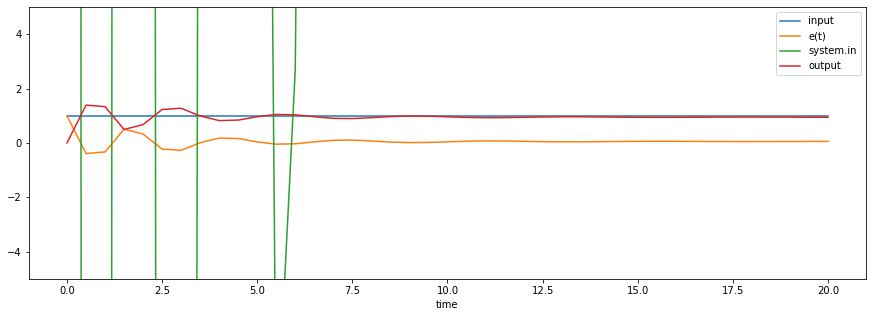

In [21]:
evaluateDesign( noise_amp=0, end_time=20, # Environment
               kp=1000, ki=2,  kf=None,       # Design
               ylim=[-5, 5],figsize=[15, 5])  # Plot

# Q3. Analyze

In [ ]:
def analyze(
    model_reference=BIOMD823, time=0, kp=1000, ki=2, kd=0, kf=None):
    """
    Create an evaluation test and plots the step response.
    
    Parameters
    ----------
    name: str
        Name of the resulting Interconncted system
    model_reference: str
        antimony string or file path or URL
    time: float
        time at which Jacobian is calculated
    kp: float
    ki: float
    kd: float
    kf: float
    
    Returns
    -------
    dict
        key: str ("H_RY", "H_NY", "H_DY")
        value: control.TransferFunction
    """
    ctlsb = ctl.ControlSBML(
        model_reference=model_reference,
        input_names=["pAkt"], output_names=["pDEPTOR"])
    Gs = ctlsb.makeTransferFunction(time=time)
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0]) + control.TransferFunction([kd, 0], [1])
    if kf is None:
        Fs = 1
    else:
        Fs = control.TransferFunction([-kf], [1, kf])
    denom = 1 + Cs*Gs*Fs
    dct = {
        "Gs": Gs,
        "H_RY": Cs*Gs/denom,
        "H_NY": -Fs/denom,
        "H_DY": Gs/denom,
    }
    return dct

# Tests
dct = analyze()

In [ ]:
dct = analyze(time=1)

In [ ]:
dct["Gs"].dcgain()

In [ ]:
dct["H_RY"].pole()

In [ ]:
dct["H_NY"]

1. Why are large control inputs required to control the mTOR system?
   * Large control inputs are required because there is a small DC gain for mTOR from pAkt to pDEPTOR.
1. Why are there no long term oscillations in the closed loop system?
   * In $H_{RY}$, There is no pole close to zero if a non-zero imaginary part.
1. How will a step increase in noise affect the system?
   * Since the DC gain of $H_{NY}$ is 0, in theory, noise will not affect the output.

# Q4. Discussion

1. The closed loop system requires that pAkt be extremely large.
1. The closed loop system requires negative values of pAkt.